In [1]:
import torch
torch.backends.cudnn.benchmark = True
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
import os
import glob
import string

from io import open

def find_files(path):
    return glob.glob(path) # 파일 리스트

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

all_letters = string.ascii_letters + ".,;'" 
n_letters = len(all_letters)  # 모든 문자+ .,; 개수 : 56개

# 유니코드 문자열을 ASCII로 변환. https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    """유니코드 -> ASCII 변환"""
    import unicodedata
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn' and c in all_letters)
    
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# 해당 폴더에서 파일 리스팅 (이름:언어명)
for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [3]:
print(f'모든 문자(all_letters)=({all_letters}), 개수(n_letters)={n_letters}')
print(f"유니코드 -> 아스키 코드로 변환(unicode_to_ascii)=({unicode_to_ascii('Ślusàrski')})")

print(f'언어명 list[0](all_categories[0])={all_categories[0]}')
print(f'성씨 dict[언어명[0]][0](category_lines[all_categories[0]][:5])='
      '{category_lines[all_categories[0]][:5]}') # 언어마다 성씨 목록 dict
print(f'전체 언어 개수(n_categories)={n_categories}')

모든 문자(all_letters)=(abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'), 개수(n_letters)=56
유니코드 -> 아스키 코드로 변환(unicode_to_ascii)=(Slusarski)
언어명 list[0](all_categories[0])=Italian
성씨 dict[언어명[0]][0](category_lines[all_categories[0]][:5])={category_lines[all_categories[0]][:5]}
전체 언어 개수(n_categories)=18


In [4]:
# 이름을 텐서로 변경.
# 하나의 문자는 크기가 (1 x n_letters) 인 one-hot vector 사용
# b = [0, 1, 0, 0, ...] -> n_letters 길이 크기
# 단어를 만들면 2차원 one-hot vector (line_length x 1 x n_letters)
# 추가적인 1차원은 배치 크기.

# all_letters 로 문자의 인덱스 리턴, 예시 "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# n_letters = 56
# 검증을 위해서 한개의 문자를 <1 x n_letters> Tensor로 변환
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def line_to_tensor(line):
    # ([5, 1, 56]) => 문장 길이:'5', 1, 단어 벡터의 차원:'56'
    tensor = torch.zeros(len(line), 1, n_letters)
    for ch_index, letter in enumerate(line):
        tensor[ch_index][0][letter_to_index(letter)] = 1
    return tensor

print(f"'A'문자의 인덱스(letter_to_index('A'))=({letter_to_index('A')})")
print(f"'J'문자 -> 텐서로 변경(letter_to_tensor('J'))={letter_to_tensor('J')}")
print(f"크기={letter_to_tensor('J').size()}")
print(f"'Jones' 문자열 -> 텐서로 변경 크기(line_to_tensor('Jones').size())="
      f"{line_to_tensor('Jones').size()}")

'A'문자의 인덱스(letter_to_index('A'))=(26)
'J'문자 -> 텐서로 변경(letter_to_tensor('J'))=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
크기=torch.Size([1, 56])
'Jones' 문자열 -> 텐서로 변경 크기(line_to_tensor('Jones').size())=torch.Size([5, 1, 56])


In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # (1, 184)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:
# 이 네트워크의 한 단계를 실행하려면 입력(현재 문자 Tensor)과 
# 이전의 은닉 상태 (처음에는 0으로 초기화)를 전달해야 함.
# 출력(각 언어의 확률)과 다음 은닉 상태 (다음 단계를 위해 유지)를 돌려 받음.

n_hidden = 128

# n_letters = 56
# n_categories = 18
rnn = RNN(n_letters, n_hidden, n_categories)

input = letter_to_tensor('A') # (1, 56)
hidden = torch.zeros(1, n_hidden) # (1, 128)
output, next_hidden = rnn(input, hidden)
# output size 는 RNN output size 로 리턴됨
print(output.shape, next_hidden.shape)

torch.Size([1, 18]) torch.Size([1, 128])


In [7]:
# 효율성을 위해서 매 단계마다 새로운 Tensor를 만들지 않고 lineToTensor 를 잘라서 사용
# Tensor의 사전 연산(pre-computing) 배치에 의해 더욱 최적화 될 수 있음

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

input = line_to_tensor('Albert') # torch.Size([6, 1, 56])
hidden = torch.zeros(1, n_hidden)
print(input[0].shape)
output, next_hidden = rnn(input[0], hidden)
print(output.shape, next_hidden.shape) # (1 x n_categories)

torch.Size([1, 56])
torch.Size([1, 18]) torch.Size([1, 128])


In [8]:
# 학습으로 들어가기 전에 도움되는 함수를 만들 때
# 첫째는 우리가 알아낸 각 카테고리의 우도인 네트워크 출력을 해석하는 것.
# 가장 큰 값의 주소를 알기 위해서 Tensor.topk 를 사용 할 수 있음
# 역자 주: 네트워크 출력(각 카테고리의 우도)으로 
# 가장 확률이 높은 카테고리 이름(언어)과 카테고리 번호 반환

def category_from_output(output):
    top_n, top_i = output.topk(1) # 값, 인덱스
    category_i = top_i[0].item() # 텐서 값에서 정수 값만 가져오기
    return all_categories[category_i], category_i

print(category_from_output(output))

('Chinese', 4)


In [9]:
import random

def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_example():
    # all_categories=18
    category = random_choice(all_categories) # 언어
    line = random_choice(category_lines[category]) # 언어 중 특정 성씨
    category_tensor = torch.tensor(
        [all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Phung
category = Italian / line = Pesaresi
category = English / line = Frey
category = Chinese / line = Pan
category = Scottish / line = Hughes
category = Russian / line = Jivoluk
category = Vietnamese / line = Giang
category = Dutch / line = Schoonraad
category = Greek / line = Paitakes
category = Italian / line = Arrighetti


In [10]:
learning_rate = 0.005
criterion = nn.NLLLoss()

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories).to(dev)

def train(category_tensor, line_tensor):
    category_tensor = category_tensor.to(dev)
    line_tensor = line_tensor.to(dev)

    hidden = rnn.initHidden().to(dev)

    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더함
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor) 
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = 'v' if guess == category else 'x (%s)' % category
        print(f'{iter} {iter / n_iters * 100}% ({timeSince(start)}) '\
              f'{loss:.4f} {line} / {guess} {correct})')

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5.0% (0m 21s) 2.6175 Ziemniak / Russian x (Polish))
10000 10.0% (0m 42s) 2.8889 Mata / Japanese x (Spanish))
15000 15.0% (1m 2s) 1.5443 Williamson / Scottish v)
20000 20.0% (1m 23s) 1.1044 Kruger / German v)
25000 25.0% (1m 42s) 2.3476 D'aramitz / Italian x (French))
30000 30.0% (2m 2s) 1.4803 Robertson / Scottish x (English))
35000 35.0% (2m 23s) 2.1122 Ton / Korean x (Vietnamese))
40000 40.0% (2m 42s) 0.9074 Perrot / French v)
45000 45.0% (3m 3s) 0.1196 Dinh / Vietnamese v)
50000 50.0% (3m 24s) 2.2039 Denzel / Polish x (German))
55000 55.00000000000001% (3m 45s) 0.6493 Feng / Chinese v)
60000 60.0% (4m 6s) 2.3483 Delbosque / French x (Spanish))
65000 65.0% (4m 26s) 2.2947 Notman / Arabic x (English))
70000 70.0% (4m 47s) 0.5569 Iida / Japanese v)
75000 75.0% (5m 9s) 0.4049 Macleod / Scottish v)
80000 80.0% (5m 28s) 1.6304 Zhitny / English x (Russian))
85000 85.0% (5m 48s) 1.7867 Han / Chinese x (Korean))
90000 90.0% (6m 7s) 1.4999 Machado / Japanese x (Portuguese))
95000 95.0% (

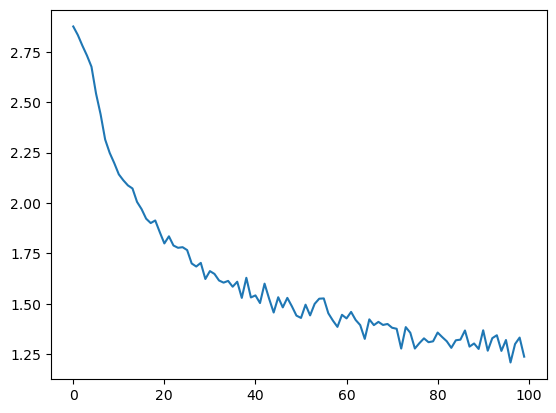

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [13]:
# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden().to(dev)
    
    line_tensor = line_tensor.to(dev)    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.58) Czech
(-1.04) Russian
(-2.82) English

> Jackson
(-1.05) English
(-1.36) Russian
(-2.15) Scottish

> Satoshi
(-1.02) Japanese
(-1.02) Italian
(-2.65) Arabic
